# Task 3
---

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
# For modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from matplotlib.colors import ListedColormap
sns.set_palette('viridis')
pd.options.mode.chained_assignment = None  # Supress warning, default='warn'

# Read Data
In this section we read the data in after the preprocessing from the preprocessing notebook

In [4]:
df = pd.read_pickle('../data/preprocessed/accepted_df_preprocessed.pkl')
print(f"Shape of df: {df.shape}")
df.head(5)

Shape of df: (1345310, 94)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,3600.0,3600.0,3600.0,36,13.99,123.03,C,C4,10.0,MORTGAGE,...,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0
1,24700.0,24700.0,24700.0,36,11.99,820.28,C,C1,10.0,MORTGAGE,...,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0
2,20000.0,20000.0,20000.0,60,10.78,432.66,B,B4,10.0,MORTGAGE,...,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0
4,10400.0,10400.0,10400.0,60,22.45,289.91,F,F1,3.0,MORTGAGE,...,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0
5,11950.0,11950.0,11950.0,36,13.44,405.18,C,C3,4.0,RENT,...,0.0,0.0,100.0,100.0,0.0,0.0,16900.0,12798.0,9400.0,4000.0


# Encode Features from categorical to numerical

In [5]:
# Preview categorical data
print(df.dtypes.value_counts())
# Get categorical columns names
cat_columns = df.select_dtypes(include=['object']).columns.tolist()
# change format
for col in cat_columns:
    df[col] = df[col].astype('category')

float64    87
object      6
int64       1
dtype: int64


In [6]:
# Label Encoding
df_ec = df.copy()
for col in cat_columns:
    df_ec[col] = df[col].cat.codes
# check
df_ec.dtypes.value_counts()

float64    87
int8        6
int64       1
dtype: int64

In [7]:
# One-Hot-Encoding
df_hoe = pd.get_dummies(data=df, columns=cat_columns, drop_first=True)
# check
df_hoe.dtypes.value_counts()

float64    87
uint8      49
int64       1
dtype: int64

In [8]:
# Binary Encoding
import category_encoders as ce
encoder = ce.BinaryEncoder(cols=cat_columns)
df_binary = encoder.fit_transform(df)
# check
df_binary.dtypes.value_counts()

float64    87
int64      19
dtype: int64

In [9]:
# Convert all values to float
df_ec = df_ec.astype(float)
df_binary = df_binary.astype(float)
df_hoe = df_hoe.astype(float)

# Create Balanced Data Set via Downsampling

0.0    1076751
1.0     268559
Name: loan_status, dtype: int64
(1345310, 106)


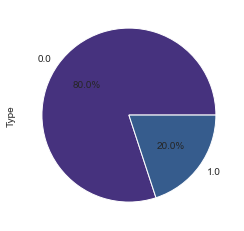

In [10]:
print(df_binary.loan_status.value_counts())
print(df_binary.shape)
df_binary.groupby('loan_status').size().plot(kind='pie', y = "loan_status", label = "Type", autopct='%1.1f%%')

In [11]:
# Take only fraction of the data
df_binary_sample = df_binary.sample(frac = 0.1)
print(df_binary_sample.shape)
print(df_binary_sample.loan_status.value_counts())

(134531, 106)
0.0    107600
1.0     26931
Name: loan_status, dtype: int64


0.0    35010
1.0    26931
Name: loan_status, dtype: int64


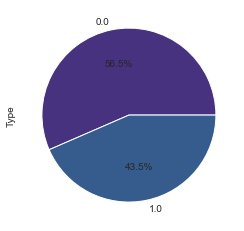

In [12]:
# Downsampling
loan_status_0 = df_binary_sample[df_binary_sample["loan_status"] == 0.0]
loan_status_1  = df_binary_sample[df_binary_sample["loan_status"] == 1.0]

loan_status_0_downsample = resample(loan_status_0,
             replace=True,
             n_samples=round(1.3*len(loan_status_1)),
             random_state=42)

df_binary_downsampled = pd.concat([loan_status_0_downsample, loan_status_1])

print(df_binary_downsampled["loan_status"].value_counts())
df_binary_downsampled.groupby('loan_status').size().plot(kind='pie', y = "loan_status", label = "Type", autopct='%1.1f%%')

In [13]:
# Fill NaNs with Median
df_binary_downsampled = df_binary_downsampled.fillna(df_binary_downsampled.median())
# Preview
df_binary_downsampled.head(5)

,loan_amnt,funded_amnt,funded_amnt_inv,term_0,term_1,int_rate,installment,grade_0,grade_1,grade_2,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
1648356,3600.0,3600.0,3388.04,0.0,1.0,11.89,119.40,0.0,1.0,0.0,...,0.0,2.0,97.9,50.0,0.0,0.0,102882.0,37444.0,14500.0,31742.0
212955,14000.0,14000.0,14000.00,0.0,1.0,5.32,421.61,1.0,0.0,0.0,...,0.0,2.0,94.1,12.5,0.0,0.0,52000.0,17923.0,44500.0,0.0
133146,18000.0,18000.0,18000.00,0.0,1.0,7.26,557.94,1.0,0.0,0.0,...,0.0,3.0,95.5,33.3,0.0,0.0,53329.0,16550.0,29100.0,17323.0
2259958,7000.0,7000.0,7000.00,0.0,1.0,5.32,210.81,1.0,0.0,0.0,...,0.0,4.0,95.5,0.0,0.0,0.0,257408.0,52986.0,15600.0,53173.0
669616,5000.0,5000.0,5000.00,0.0,1.0,11.47,164.81,0.0,1.0,0.0,...,0.0,2.0,100.0,33.3,0.0,0.0,70808.0,50419.0,11600.0,48508.0


# Data Split
In this section we split the data into a training and test set. The corresponding model is then trained on the training set and tested on the test set.

In [17]:
# Fraction of test data
TEST_SIZE = 0.3

X = df_binary_downsampled.drop("loan_status", axis=1)
y = df_binary_downsampled["loan_status"]

# Split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42, stratify=y)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (43358, 105)
Shape of X_test: (18583, 105)
Shape of y_train: (43358,)
Shape of y_test: (18583,)


In [18]:
# Init object
scaler = StandardScaler()
# Scale X_train
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled)
# Scale X_test
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled)

# Preview X_train_scaled
X_train_scaled.head(5)

,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
0,1.049317,1.050659,1.013255,-0.627776,0.627776,-0.945786,1.212021,1.200496,-0.954183,-0.858140,...,-0.182556,-1.225694,0.657992,-0.268481,-0.364725,-0.125193,-0.195293,0.361437,5.305087,-0.994779
1,0.592604,0.593795,0.596446,-0.627776,0.627776,-1.219050,0.677753,1.200496,-0.954183,-0.858140,...,-0.182556,-0.680693,0.657992,0.087574,-0.364725,-0.125193,0.057763,1.893514,0.689571,2.135423
2,1.734385,1.735954,1.735534,1.592924,-1.592924,0.082496,0.972709,-0.832989,-0.954183,1.165311,...,-0.182556,-0.135691,0.414851,-1.336647,-0.364725,-0.125193,-0.353400,0.339457,1.167047,-0.234411
3,-1.005889,-1.005228,-1.002274,-0.627776,0.627776,-0.391161,-0.947954,-0.832989,-0.954183,1.165311,...,-0.182556,-0.680693,0.657992,-0.388116,-0.364725,-0.125193,-0.677146,-0.493088,-0.422898,-0.296621
4,0.535515,0.536687,0.539349,-0.627776,0.627776,-0.391161,0.760763,-0.832989,-0.954183,1.165311,...,-0.182556,1.499314,0.657992,-1.336647,-0.364725,6.570673,-0.276334,0.089364,0.935692,0.015820


---
# Task 3: Logistic Regression In Sample

In [19]:
# Fit Model
lr = LogisticRegression(max_iter=500)
lr.fit(X_train_scaled, y_train)

# Predict In Sample
y_pred = lr.predict(X_train_scaled)

## Test Model

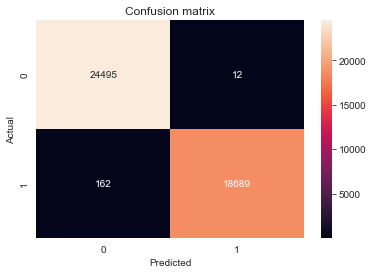

________________________________________________________________________________
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     24507
         1.0       1.00      0.99      1.00     18851

    accuracy                           1.00     43358
   macro avg       1.00      1.00      1.00     43358
weighted avg       1.00      1.00      1.00     43358

Information:
Precision: Percentage of correct positive predictions relative to total positive predictions
Recall: Percentage of correct positive predictions relative to total actual positives.
F1 Score: A weighted harmonic mean of precision and recall. The closer to 1, the better the model.
________________________________________________________________________________


In [20]:
# Plot Confusion matrics
cm = confusion_matrix(y_true=y_train, y_pred=y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot classification report
print(80 * "_")
print(classification_report(y_true=y_train, y_pred=y_pred))
print("Information:")
print("Precision: Percentage of correct positive predictions relative to total positive predictions")
print("Recall: Percentage of correct positive predictions relative to total actual positives.")
print("F1 Score: A weighted harmonic mean of precision and recall. The closer to 1, the better the model.")
print(80 * "_")

---
# Task 4

Comparing
* logistic regression,
* classification tree,
* random forest,
* bagging,
* support vector machine (with two kernel functions),
* and neural network
for default prediction based on the out-of-sample performance measures (at least three different measures).

In [ ]:
# Ale: Ist bereits skaliert (siehe oben bei Task 3)
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)

In [21]:
%%time
models = []

models.append(("LogisticRegression",LogisticRegression(fit_intercept=True, max_iter=1000, solver="saga")))
models.append(("DecisionTree",DecisionTreeClassifier()))
models.append(("RandomForest",RandomForestClassifier()))
models.append(("BaggingCLF",BaggingClassifier()))
models.append(("SVC",SVC(kernel='rbf')))
models.append(("SVC",SVC(kernel="linear")))
models.append(("NeuronalNetwork", MLPClassifier(alpha=1, max_iter=1000)))

results = []
names = []
for name,model in tqdm(models):
    result = cross_val_score(model, X_train_scaled, y_train,  cv=3)
    names.append(name)
    results.append(result)

for i in range(len(names)):
    print(names[i],results[i].mean())

  0%|          | 0/7 [03:26<?, ?it/s]


KeyboardInterrupt: 

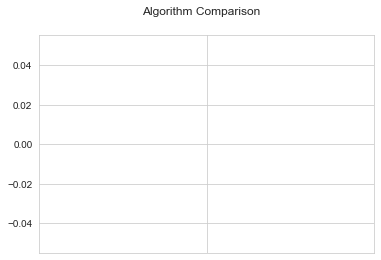

In [22]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [23]:
# data point plot - total, train, test
figure, ax = plt.subplot(3, len(models))

cm_bright = ListedColormap(["#FF0000", "#0000FF"])
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

for ax, model in zip(ax.flatten(), models):
    
    name = model[0]
    clf = model[1]
    
    clf.fit(X_train_scaled, y_train)
    score = clf.score(X_test_scaled, y_test)

    # Plot the training points
    ax.scatter(
        X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
    )
    # Plot the testing points
    ax.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], c=y_test,
        cmap=cm_bright,
        edgecolors="k",
        alpha=0.6,
    )

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(f"{name}")
    ax.text(
        x_max - 0.3,
        y_min + 0.3,
        ("%.2f" % score).lstrip("0"),
        size=15,
        horizontalalignment="right",
    )

plt.tight_layout()
plt.show()

ValueError: Illegal argument(s) to subplot: (3, 7)

<Figure size 432x288 with 0 Axes>